# BCAUSE

_BCAUSE_ is a python package for causal and counterfactual reasoning using _probabilistic graphical models_, in particular discrete Bayesian networks (BNs) and structural causal models (SCMs).

## Basic example of use

### Import modules
First, import the required modules for this example.

In [1]:
import networkx as nx
from bcause.factors import DeterministicFactor, MultinomialFactor
from bcause.models.cmodel import StructuralCausalModel
from bcause.inference.causal.elimination import CausalVariableElimination
from bcause.inference.causal.multi import EMCC
from bcause.util import randomUtil

### Model definition

First, let's define the graph of a SCM as an object of class `networkx:DiGraph`:

In [2]:
# Define a DAG and the domains
dag = nx.DiGraph([("X", "Y"), ("U", "Y"), ("U", "X")])

The domain of the variables are defined as a dictionary where the keys are the variable names and the values are the posible states. Variables should be of type `str` whereas each posible state can be of any hashable type (e.g., integers, str, etc.)

In [3]:
domains = dict(X=["x1", "x2"], Y=["y1","y2"], U=["u1", "u2", "u3", "u4"])

The structural equations are defined as deterministic factors. The values can be specified as a list, by iterating first on the rightmost parent variable (following the variable in the domain dictionary).

In [4]:
domx = {'U': domains['U'], 'X': domains['X']}
fx = DeterministicFactor(domx, right_vars=["U"], values=["x1", "x2", "x2", "x1"])
fx

<DeterministicFactor fX(U), cardinality = (U:4,X:2), values=[x1,x2,x2,x1]>

Alternatively, the values can be specified as a multidimensional array, in which the inner dimension is the rightmost variable in the dictionary.

In [5]:
# the inner dimension is the rightmost variable (following the variable in the domain dict)
values = [['y1', 'y1', 'y2', 'y1'],['y2', 'y2', 'y1', 'y1']]
domy = {'X': domains["X"], 'U': domains["U"], 'Y': domains["Y"]}
fy = DeterministicFactor(domy, left_vars=["Y"], values=values)
fy

<DeterministicFactor fY(X,U), cardinality = (X:2,U:4,Y:2), values=[y1,y1,y2,y1,...,y1]>

For the exogenous variables, the associated probability tables are specified as object of class `MultinomialFactor`. In this case, the values correspond with the probability values of each state.

In [6]:
domu =  {"U": domains["U"]}
pu = MultinomialFactor(domu, values=[.2, .2, .6, .0])
pu

<MultinomialFactor P(U), cardinality = (U:4), values=[0.2,0.2,0.6,0.0]>

In [7]:
model = StructuralCausalModel(dag, [fx, fy, pu])
model

<StructuralCausalModel (X:2,Y:2|U:4), dag=[X|U][Y|X:U][U]>

### Model attributes and methods

First, the graph can be drawn as follows.

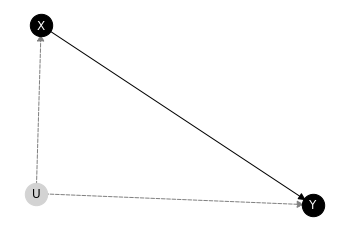

In [8]:
model.draw()

The model contains lists indicating which nodes are enodgenous and which are exogenous.

In [9]:
model.endogenous, model.exogenous

(['X', 'Y'], ['U'])

Additionaly, a dictionary with the associated probability tables can be obtained. By default, structural equations are transformed into degenerated multinomial factors.

In [10]:
model.factors

{'X': <MultinomialFactor P(X|U), cardinality = (U:4,X:2), values=[1.0,0.0,0.0,1.0,...,0.0]>,
 'Y': <MultinomialFactor P(Y|X,U), cardinality = (X:2,U:4,Y:2), values=[1.0,0.0,1.0,0.0,...,0.0]>,
 'U': <MultinomialFactor P(U), cardinality = (U:4), values=[0.2,0.2,0.6,0.0]>}

The SCM can be transformed into a BN with the same structure.

In [11]:
model.to_bnet()

<BayesianNetwork (X:2,Y:2,U:4), dag=[X|U][Y|X:U][U]>

The decomposition in connected componentes:

In [12]:
model.ccomponents

[{'U', 'X', 'Y'}]

The BN resulting of the Q-factorisation:

In [13]:
model.get_qbnet()

<BayesianNetwork (X:2,Y:2), dag=[X][Y|X]>

### Inference on fully specified SCM

If the exogenous distributions are known, causal and counterfactual inference can be done as follows.

In [14]:
# Run causal inference with Variable Elimination
cve = CausalVariableElimination(model)
cve.causal_query("Y", do=dict(X="x1"))

<MultinomialFactor P(Y), cardinality = (Y:2), values=[0.4,0.6]>

In [15]:
# Run a counterfactual query
cve.counterfactual_query("Y",do=dict(X="x1"), evidence=dict(X="x1"))

<MultinomialFactor P(Y_1), cardinality = (Y_1:2), values=[1.0,0.0]>

### Inference from data

Alternatively, for the cases in which only endogenous observations are available, bcause implements the approximate method "Expectation Maximization for Causal Computation (EMCC)", described in the following paper.


Zaffalon, M., Antonucci, A., Cabañas, R., Huber, D., & Azzimonti, D. (2024). Efficient computation of counterfactual bounds. International Journal of Approximate Reasoning, 109111. https://doi.org/10.1016/j.ijar.2023.109111

For illustrating this, let's first sample some data.


In [23]:
randomUtil.seed(1)
data = model.sampleEndogenous(1000)
data

,X,Y
0,x2,y1
1,x2,y1
2,x1,y1
3,x2,y2
4,x1,y1
...,...,...
995,x2,y1
996,x2,y2
997,x2,y1
998,x2,y2


The inference engine takes as arguments the model, the maximum number of iterations of each independent EM run and the number of EM runs.

In [24]:
inf = EMCC(model, data, max_iter=100, num_runs=20)

Then, we can proceed with any causal or counterfactual query.

In [25]:
p = inf.causal_query("Y", do=dict(X="x1"))
p

<IntervalProbFactor P(Y), cardinality = (Y:2), values_low=[0.38899999999999996,0.611], values_up=[0.389,0.611]>

In [26]:
p = inf.counterfactual_query("Y", do=dict(X="x1"), evidence=dict(X="x2"))
p

<IntervalProbFactor P(Y_1), cardinality = (Y_1:2), values_low=[0.23337515683814303,0.766624843161857], values_up=[0.23337515683814306,0.766624843161857]>

In [27]:
inf.prob_necessity("X","Y")

[0.011692406857384964, 0.9015783677357316]

In [28]:
inf.prob_sufficiency("X","Y")


[1.0, 1.0]

In [22]:
inf.prob_necessity_sufficiency("X","Y")

[0.18837355859204916, 0.3690204086503535]